In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "dataset"
print(os.listdir(dataset_path))

['Drowsy', 'Non Drowsy']


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip to generalize left/right faces
    transforms.RandomRotation(10),  # Slight rotation to account for natural head tilt
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # More variability in lighting
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),  # Small shifts & rotations
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Simulate motion blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=dataset_path, transform=transform)

In [4]:
train_val_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

train_dataset, val_dataset = random_split(train_val_dataset, [0.75, 0.25])

subset_train = Subset(train_dataset,range(1000))
subset_val = Subset(val_dataset, range(1000))
subset_test = Subset(test_dataset, range(1000))

# Create DataLoaders
train_loader = DataLoader(subset_train, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(subset_val, batch_size=128, shuffle=False)
test_loader = DataLoader(subset_test, batch_size=128, shuffle=False)

# Print dataset sizes
print(f"✅ Training Samples: {len(train_dataset)}")
print(f"✅ Validation Samples: {len(val_dataset)}")
print(f"✅ Test Samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

✅ Training Samples: 25077
✅ Validation Samples: 8358
✅ Test Samples: 8358
Classes: ['Drowsy', 'Non Drowsy']


In [5]:
def plot_images_grid(dataloader, mean, std):
    for images, labels in dataloader:
        break
    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    for ax, image, label in zip(axes.flatten(), images, labels):            
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        image = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(image)
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Train set


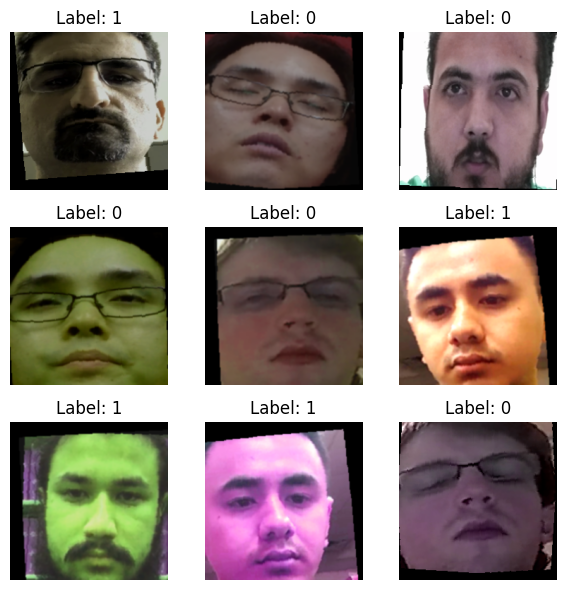

Valid set


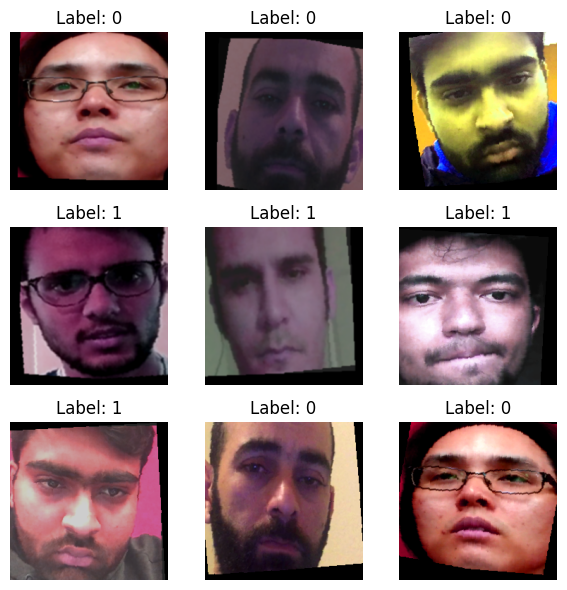

Test set


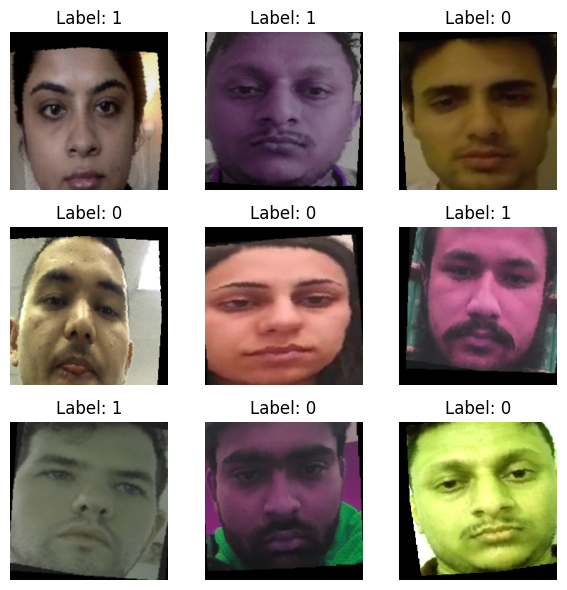

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
print("Train set"); plot_images_grid(train_loader, mean, std)
print("Valid set"); plot_images_grid(val_loader, mean, std)
print("Test set"); plot_images_grid(test_loader, mean, std)

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input: 3xHxW
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # H/2 x W/2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # H/4 x W/4

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # 128 x 1 x 1
        )
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten to batch_size x 128
        x = self.dropout(x)
        x = self.classifier(x)
        return x


In [8]:
model = CNN(num_classes=2)
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [10]:
checkpoint_path = "model3_checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    CNN.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    print(f"Checkpoint Loaded! Resuming from Epoch {start_epoch+1} with best loss {best_loss:.4f}")
else:
    start_epoch = 0
    best_loss = float("inf")

In [11]:
# Set up model, optimizer, and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Paths for saving
checkpoint_path = "checkpoint.pth"
best_model_path = "best_model.pth"
log_path = "training_log.txt"

In [12]:
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    CNN.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    print(f"🔄 Resuming training from Epoch {start_epoch}...")
else:
    start_epoch = 0
    best_loss = float('inf')

In [13]:
epochs = 30
train_losses = []
val_losses = []
val_accuracies = []

patience = 3
counter = 0

In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [15]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / total
    val_accuracy = correct / total

    return avg_val_loss, val_accuracy

In [16]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    print("Training complete.")
    return model, train_loss, val_loss, val_acc

In [17]:
def plot_training_metrics(train_losses, val_losses, val_accuracies, save_path="training_results.png"):
    """
    Plot training loss, validation loss, and validation accuracy over epochs.

    Parameters:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
        val_accuracies (list): Validation accuracy per epoch
        save_path (str): Path to save the resulting plot
    """
    plt.figure(figsize=(12, 6))

    # 🔵 Loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # 🟢 Accuracy vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f" Training plot saved to: {save_path}")

In [18]:
trained_model, train_loss, val_loss, val_acc = train_model(model, train_loader, val_loader, device, epochs, lr=1e-4)


Epoch 1/30


Training: 100%|██████████| 8/8 [00:33<00:00,  4.15s/it]


Train Loss: 0.7028, Accuracy: 0.5390
Val   Loss: 0.6934, Accuracy: 0.4820
Best model saved!

Epoch 2/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


Train Loss: 0.6945, Accuracy: 0.5470
Val   Loss: 0.6854, Accuracy: 0.5680
Best model saved!

Epoch 3/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]


Train Loss: 0.6869, Accuracy: 0.5670
Val   Loss: 0.6747, Accuracy: 0.5720
Best model saved!

Epoch 4/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


Train Loss: 0.6766, Accuracy: 0.5720
Val   Loss: 0.6774, Accuracy: 0.5440

Epoch 5/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


Train Loss: 0.6809, Accuracy: 0.5600
Val   Loss: 0.6742, Accuracy: 0.5630

Epoch 6/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]


Train Loss: 0.6772, Accuracy: 0.5660
Val   Loss: 0.6652, Accuracy: 0.5590

Epoch 7/30


Training: 100%|██████████| 8/8 [00:33<00:00,  4.14s/it]


Train Loss: 0.6733, Accuracy: 0.5990
Val   Loss: 0.6655, Accuracy: 0.5890
Best model saved!

Epoch 8/30


Training: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]


Train Loss: 0.6836, Accuracy: 0.5760
Val   Loss: 0.6616, Accuracy: 0.5960
Best model saved!

Epoch 9/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]


Train Loss: 0.6699, Accuracy: 0.5730
Val   Loss: 0.6567, Accuracy: 0.5990
Best model saved!

Epoch 10/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]


Train Loss: 0.6667, Accuracy: 0.5770
Val   Loss: 0.6565, Accuracy: 0.6030
Best model saved!

Epoch 11/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


Train Loss: 0.6841, Accuracy: 0.5590
Val   Loss: 0.6526, Accuracy: 0.6090
Best model saved!

Epoch 12/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


Train Loss: 0.6602, Accuracy: 0.5990
Val   Loss: 0.6555, Accuracy: 0.5900

Epoch 13/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.04s/it]


Train Loss: 0.6634, Accuracy: 0.5900
Val   Loss: 0.6579, Accuracy: 0.5950

Epoch 14/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]


Train Loss: 0.6649, Accuracy: 0.5900
Val   Loss: 0.6614, Accuracy: 0.5870

Epoch 15/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]


Train Loss: 0.6655, Accuracy: 0.5900
Val   Loss: 0.6692, Accuracy: 0.5710

Epoch 16/30


Training: 100%|██████████| 8/8 [00:33<00:00,  4.14s/it]


Train Loss: 0.6601, Accuracy: 0.6010
Val   Loss: 0.6564, Accuracy: 0.6140
Best model saved!

Epoch 17/30


Training: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]


Train Loss: 0.6519, Accuracy: 0.6180
Val   Loss: 0.6508, Accuracy: 0.6140

Epoch 18/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]


Train Loss: 0.6496, Accuracy: 0.6050
Val   Loss: 0.6418, Accuracy: 0.6220
Best model saved!

Epoch 19/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]


Train Loss: 0.6619, Accuracy: 0.5940
Val   Loss: 0.6517, Accuracy: 0.6210

Epoch 20/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


Train Loss: 0.6551, Accuracy: 0.6060
Val   Loss: 0.6619, Accuracy: 0.5900

Epoch 21/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]


Train Loss: 0.6566, Accuracy: 0.6040
Val   Loss: 0.6578, Accuracy: 0.5980

Epoch 22/30


Training: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]


Train Loss: 0.6705, Accuracy: 0.5910
Val   Loss: 0.6327, Accuracy: 0.6380
Best model saved!

Epoch 23/30


Training: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


Train Loss: 0.6502, Accuracy: 0.6120
Val   Loss: 0.6443, Accuracy: 0.6100

Epoch 24/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]


Train Loss: 0.6486, Accuracy: 0.6180
Val   Loss: 0.6445, Accuracy: 0.6200

Epoch 25/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


Train Loss: 0.6635, Accuracy: 0.5930
Val   Loss: 0.6506, Accuracy: 0.6060

Epoch 26/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]


Train Loss: 0.6540, Accuracy: 0.6050
Val   Loss: 0.6426, Accuracy: 0.6100

Epoch 27/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


Train Loss: 0.6572, Accuracy: 0.6150
Val   Loss: 0.6557, Accuracy: 0.5890

Epoch 28/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]


Train Loss: 0.6511, Accuracy: 0.6030
Val   Loss: 0.6447, Accuracy: 0.6370

Epoch 29/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]


Train Loss: 0.6366, Accuracy: 0.6510
Val   Loss: 0.6444, Accuracy: 0.6070

Epoch 30/30


Training: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]
                                                         

Train Loss: 0.6570, Accuracy: 0.6140
Val   Loss: 0.6418, Accuracy: 0.6290
Training complete.


In [20]:
# Define the number of output classes
NUM_CLASSES = len(dataset.classes)

# Create the model (classifier already defined correctly inside)
model = CNN(num_classes=NUM_CLASSES)  # or whatever your class is called

# Load trained weights
model.load_state_dict(torch.load("best_model.pth"))

# Move to device
model = model.to(device)
model.eval()

print(f"Model loaded successfully! Ready for {NUM_CLASSES} classes.")

Model loaded successfully! Ready for 2 classes.


In [21]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = (correct / total) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 60.79%


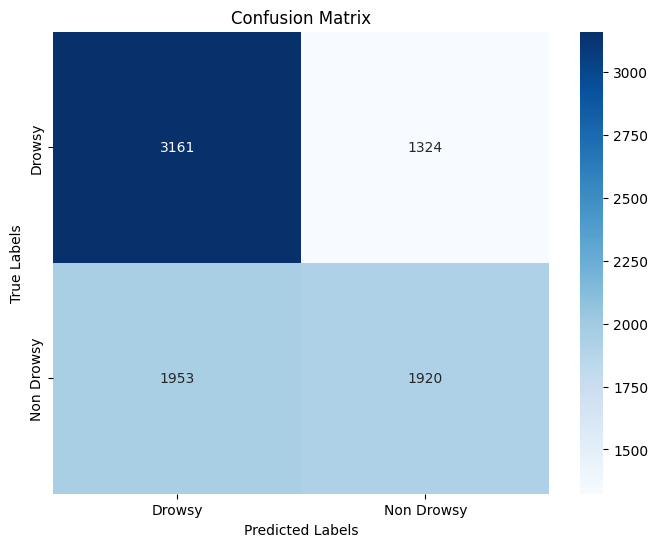

In [22]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()